# Hierachical cluster odor spectra across animals

In [1]:
%matplotlib inline

In [10]:
import sys
import os
toplevelpath = os.path.realpath(os.path.pardir)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import glob, csv, pickle, os, json
import matplotlib, scipy
from collections import defaultdict, OrderedDict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage,dendrogram
from matplotlib import gridspec
from sklearn.manifold import MDS

import copy
from regnmf import ImageAnalysisComponents as ia

from bootstrap_prediction import bootstrap_predictor as bp
from bootstrap_prediction import datastructures as ds
# workaround because fspaces.pik (and multivarreg.pik below) was created before 
# refactoring datastructures and bootstrap_predictor into bootstrap_prediction
sys.modules['datastructures'] = ds
sys.modules['bootstrap_predictor'] = bp

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [15]:
fig_dim = (7.48,9.4)
global_fs= 7 

layout = {   'axes.labelsize': 7,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular',
             'legend.fontsize': 7
             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

## Prepare Analysis

#### Specify parameter

In [22]:
method = 'nnmf_150_sm2_convex_sp*_ios_meas' #'sica_200_ios_meas' #
animals =  ['111210sph', '111221sph','111222sph', '120107', '120119', '120121', '120125']
stimulusdrive = 0.4 # maximale trial2trial correlation distance (aka 1-correlation) of modes to be included
min_activation = 0.2 # maximale activation strength of modes to be included

basepath = os.path.join('/media/jan/BackupWork/BackupSep2024/MOBData/')
#basepath = os.path.join(toplevelpath, 'glomcentric_data')
datapath = '/media/jan/BackupWork/Documents/NewAnalysis'
#datapath = os.path.join(toplevelpath, 'glomcentric_data')
factorization_path = os.path.join(datapath, 'MOBdecomposed')
bg_path = os.path.join(datapath, 'MOBconverted')
cas2name_file = os.path.join(datapath, 'DataDicts', 'Name2MomCas.tab')
cas2molid_file = os.path.join(basepath, 'ChemBase','odors_dez2013','cas2molid.csv')
cluster_file = os.path.join(datapath, 'DataDicts', 'cluster_assignment.json')
spec_savepath = os.path.join(datapath, 'DataDicts')
vis_path = os.path.join(datapath, 'Vis')
clustering_savepath = os.path.join(vis_path, 'Clustering')

fingerprinted_specfile = os.path.join(datapath, 'DataDicts', 
                                      'spectra_correlation_average_nnmf_150_sm2_convex_sp_ios_meas', 'ts')

#### Define Functions to process hierachichal cluster (linkages)

In [23]:
def return_all_childs(mylinkage, parent):
    ''' recursive function returns all leafs of parent node in mylinkage'''    
    num_leaves = mylinkage.shape[0]+1
    if parent<num_leaves:
        return [int(parent)]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return return_all_childs(mylinkage, parent=leftchild) + return_all_childs(mylinkage, parent=rightchild)

def return_all_links(mylinkage, parent):
    ''' recursive function returns all links of parent node in mylinkage''' 
    num_leaves = mylinkage.shape[0]+1
    if parent<num_leaves:
        return [parent]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return [parent] + return_all_links(mylinkage, parent=leftchild) + return_all_links(mylinkage, parent=rightchild)

def color_clusters(cluster, color_dict = None):
    ''' creates link-coloring function to color each cluster (given by parent node) '''
    cluster_colors = defaultdict(lambda: '0.5')
    for clust_ix, cluster_parent in enumerate(cluster):
        clust_color = color_dict[cluster_parent] if color_dict else plt.cm.prism(1.*clust_ix/len(cluster)) 
        clust_color = matplotlib.colors.rgb2hex(clust_color)
        colordict_update = {i: clust_color for i in return_all_links(link, cluster_parent+link.shape[0]+1)}
        cluster_colors.update(colordict_update)
    return lambda node: cluster_colors[node]

#### Define function to create combined timeseries of all animals

In [24]:
def load_combined_series(allIDs, filemask, thres, min_strength, factorization_path):
    ''' function to load and preprocess timeseries of multiple animals '''
    
    allgood, turn = [], []
    for measID in allIDs:
        
        # load timeseries
        ts = ia.TimeSeries()
        filename = glob.glob(os.path.join(factorization_path, measID, filemask+'.npy'))
        assert len(filename)==1
        ts.load(filename[0].split('.')[0])
        ts.label_stimuli = [i.split('_')[0] for i in ts.label_stimuli]
        if '_l_' in ts.name: 
            turn.append(measID)
            ts.base.set_series(ts.base.shaped2D()[:,::-1])
        ts.name = measID
        
        # calc odor spectrum of modes
        signal = ia.TrialMean()(ia.CutOut((2, 5))(ts))        
        # calc t2t correlation, exclude modes with t2t < thres
        mode_cor = ia.CalcStimulusDrive()(signal)
        signal = ia.SelectObjects()(signal, mode_cor._series.squeeze()<thres)
        
        # calc single odor response
        signal = ia.SingleSampleResponse()(signal)
        
        # selected only modes with maximal activation above min_strength
        strength = np.max(signal._series,0)
        signal = ia.SelectObjects()(signal, strength>min_strength)
        
        allgood.append(signal)
        
    allgood = ia.ObjectConcat(unequalsample=True)(allgood)
    return allgood, turn

#### Read in data

In [25]:
featurespaces = pickle.load(open(os.path.join(basepath, 'DataDicts','fspaces.pik')))

In [67]:
cas2molid = {l[0]:l[1] for l in csv.reader(open(cas2molid_file))}
cas2name = {l[0]:l[1] for l in csv.reader(open(cas2name_file),  delimiter='\t')}
molid2name = {v:cas2name[k] for k,v in cas2molid.items() if k in cas2name}

ts, turn = load_combined_series(animals, method, stimulusdrive, min_activation, factorization_path)

# load background images, turn if left bulb
bg_dict = {measID: plt.imread(os.path.join(bg_path, measID, 'bg.png')) for measID in animals}
for ani in turn:
    bg_dict[ani] = bg_dict[ani][::-1]

common sample  46
111210sph  reduced from  46
111221sph  reduced from  47
111222sph  reduced from  46
120107  reduced from  46
120119  reduced from  46
120121  reduced from  46
120125  reduced from  52


In [68]:
fspace = 'edragon-eva5' # 'haddad' # 
feat = copy.deepcopy(featurespaces[fspace])
feat.zscore()

available = np.array([int(cas2molid[i.strip()]) in feat.obj_name for i in ts.label_stimuli])
ts_pruned = ia.SelectTrials()(ts, available)
norm = np.sum(np.abs(ts_pruned._series),0)
ts_pruned._series /= norm

pos = [feat.obj_name.index(int(cas2molid[i.strip()])) for i in ts_pruned.label_stimuli] 
fspace_data = feat.data[pos]

#### Calculate barycenter of glomeruli in feature space

In [69]:
centers = np.dot(fspace_data.T, ts_pruned._series)
ts._series = centers
ts.label_stimuli = featurespaces[fspace].feat_name

#ts._series = np.hstack([np.mean(fspace_data,0).reshape((-1,1)), centers])
#ts.label_objects = ['center'] + ts.label_objects

In [70]:
print fspace_data.T.shape
print ts_pruned._series.shape
print centers.shape

(2400, 44)
(44, 405)
(2400, 405)


In [71]:
if False:
    mask = np.sqrt(np.sum((ts._series - np.mean(fspace_data,0).reshape((-1,1)))**2, 0)) > 5
    ts = ia.SelectObjects()(ts, mask)

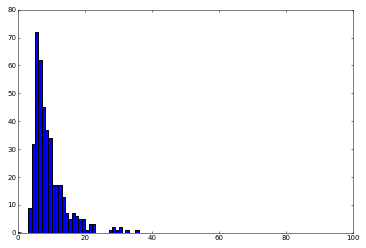

In [72]:
plt.hist(np.sqrt(np.sum((ts._series - np.mean(fspace_data,0).reshape((-1,1)))**2, 0)), np.linspace(0,100,101))
plt.show()

In [75]:
ts._series = ts._series - np.mean(fspace_data,0).reshape((-1,1))

## Hierachical cluster data

Plots a hierachical clustering. Colors cluster as defined in the file specified in cluster_file. Please add new cluster manually to cluster_file. 

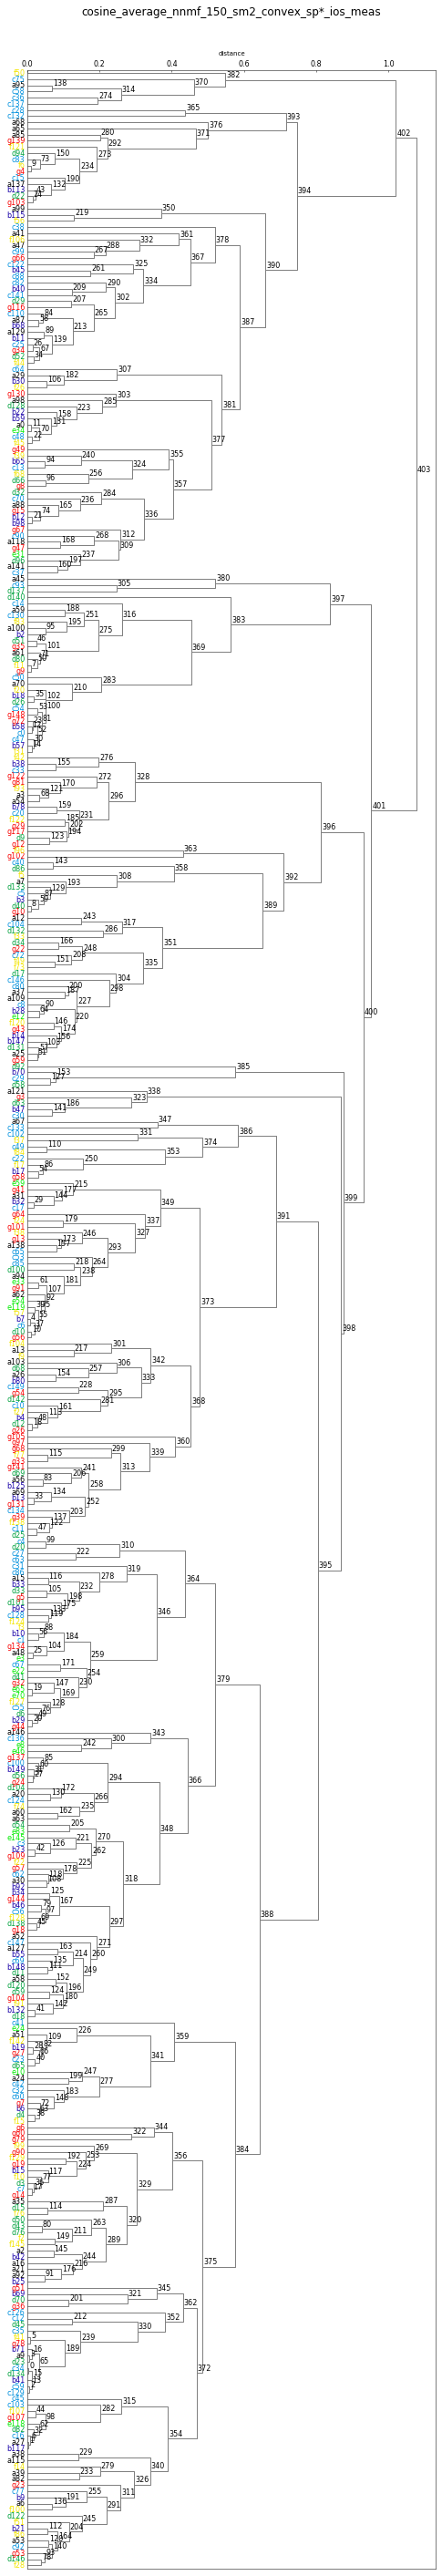

In [77]:
load_cluster = False # if already cluster assignments exist, load them
cluster_metric = 'cosine'
linkage_scheme = 'average'

title = '_'.join((cluster_metric, linkage_scheme, method))
cluster = json.load(open(cluster_file))[title] if load_cluster else None   

# create hierachical clustering
dist = pdist(ts._series.T, metric = cluster_metric)
#dist= np.sqrt(dist)
link = linkage(dist, method = linkage_scheme)

# create function to color previous defined cluster if exist. Else color everything grey.
link_coloring = color_clusters(cluster) if cluster else (lambda node: '0.5')
    
# create labels with abbreviations for animals. 
pseudo = dict(zip(animals, 'abcdefghij'))
pseudo['center'] = 'center'
pseudo_inv = {v: k for k, v in pseudo.items()}
new_labels = [pseudo[i.split('_')[0]] + i.split('_mode')[-1] for i in ts.label_objects]
# define color for each animal
animal_colors = [plt.cm.spectral(1.*animals.index(i.split('_')[0])/len(animals)) if i.split('_')[0] in animals else '0.5'
                 for i in ts.label_objects]

# plot hierachical clustering
fig = plt.figure(figsize=(7,len(new_labels)/10.))
ax = fig.add_axes([0.1,0.01,0.89,0.94])
d = dendrogram(link, link_color_func=link_coloring,  orientation='left',  count_sort='descending', labels=new_labels)
#ax.set_xlim((0,0.2))

# label coloring
for l_ind, l in enumerate(ax.yaxis.get_ticklabels()):
    mode = d['leaves'][l_ind]
    l.set_color(animal_colors[mode])
  
# annotate nodes with node id
node_order = list(np.sort(np.array(d['dcoord'])[:,1]))
for di, dd in zip(d['icoord'], d['dcoord']):
    y = 0.5 * sum(di[1:3])
    x = dd[1]
    ix = node_order.index(dd[1])
    ax.annotate("%d" % ix, (x, y), xytext=(1,1), textcoords='offset points', va='bottom', ha='left', size=8)    
   
# decorate axis
ax.set_xlabel('distance')
ax.yaxis.set_tick_params(labelsize=8)
ax.xaxis.set_tick_params(labelsize=8)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_title(title, y=1.02)

#fig.savefig('test.pdf')

#plt.show()

## Plot location and spectra of cluster

#### Functions to create cluster visualization

In [78]:
def plot_location(ts, link, cluster, bg_dict, ax_dict, color_dict, face=True, base_thres=0.3):
    ''' plot cluster location'''
    
    # plot bg
    for axname,ax in ax_dict.items():
        bg = bg_dict[axname]
        ax.imshow(bg_dict[axname], interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0])
        ax.set_axis_off()

    # plot location and timecouses of clusters
    for clust in cluster:    
        color = color_dict[clust]
        spec_collection = []
        for node in return_all_childs(link,clust+link.shape[0]+1):
            # get animal of cluster member
            measID = ts.label_objects[node].split('_')[0]
            # print pixel participation
            mode = ts.base.shaped2D()[node]    
            if face:
                ax_dict[measID].contourf(mode, [base_thres,1], colors=[color], alpha=0.5)
            else:
                ax_dict[measID].contour(mode, [base_thres], colors=[color], alpha=0.5, linewidths=[2])

#### Chemical distance to MOR18-2

In [85]:
cluster_id = 98 
metric = 'cosine' 
what = ts

protoype_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
prototype = np.mean(what._series[:,protoype_idx],1)
cor = squareform(pdist(np.hstack([prototype[:,np.newaxis], what._series]).T, metric))[0,1:]

/home/jan/Apps/virtenv/standard/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [97]:
np.where(cor<0.2)

(array([ 15,  87, 112, 132, 182, 187, 243, 252, 278, 326, 392]),)

In [98]:
cor.shape

(405,)

### Chemotopic Clustering

In [86]:
cdict = {'red': ((0, 0, 0),
                 (0.075, 1, 1),
                 (0.2, 1, 1),
                 (1, 1, 1)),
         'green': ((0, 1, 1),
                 (0.075, 1, 1),
                 (0.2, 0.5, 0.5),
                 (1, 0, 0)),
         'blue':  ((0, 0, 0),
                 (0.075, 0, 0),
                 (0.2, 0, 0),
                 (1, 0, 0))}
RdGr_compact = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

In [87]:
factor = 1 #/3.

RdGr_compact = matplotlib.colors.ListedColormap([plt.cm.RdYlGn_r(i**factor) for i in np.linspace(0,1,101)], name='my_name')

link2 = link.copy()
link2[:,2] = (link[:,2])**factor

/home/jan/Apps/virtenv/standard/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jan/Apps/virtenv/standard/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


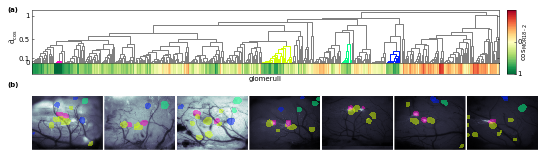

In [101]:
yticks = [0, 0.1, 0.5, 1]
cluster = [98, 316, 358,349] #,342,356,352,343,370,372,367,375,377]#[324, 298, 352, 360, 354, 365, 363, 258, 385, 359, 366, 369, 384, 401, 397]
num_cluster = len(cluster)

fig = plt.figure(figsize=fig_dim)
gs_meta = matplotlib.gridspec.GridSpec(2, 1, bottom=0.7, top = 0.99, left = 0.05, right=0.99, 
                                       height_ratios=[1,1.4,num_cluster*0.15], hspace=0.04)

num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow_r(1.*cluster.index(clust)/num_cluster) for clust in cluster}

gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 3, gs_meta[0], hspace=0.01, height_ratios=[5,1], 
                                                     wspace=0.05, width_ratios=[16.5,0.3,0.5])

# plot dendrogarm
ax = fig.add_subplot(gs_top[0,0])
top = gs_meta[0].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(a)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
d = dendrogram(link2, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
ax.set_xticks([])
ax.set_yticks([i**factor for i in yticks])
ax.set_yticklabels(yticks)
ax.set_ylabel('$\hat{d}_{cos}$', labelpad=-1)
#ax.set_ylim([0,0.2])

# plot MOR18-2 correlation
ax = fig.add_subplot(gs_top[1,0])
im = ax.imshow(((cor[d['leaves']]).reshape((1,-1))), cmap= RdGr_compact, interpolation='none', 
               aspect='auto', vmin=0, vmax=2)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('glomeruli', labelpad=2)
# colorbar
axbar = fig.add_subplot(gs_top[:,1])
cbar = plt.colorbar(im, cax=axbar)
cbar.set_ticks([0,1])
cbar.set_ticklabels([1,0])
cbar.set_label('$cos_{MOR18-2}$', labelpad=-2)

# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1,:], wspace=0.02)
top = gs_meta[1].get_position(fig).corners()[1,1]
fig.text(0.005, top-0.01, '(b)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts, link, cluster, bg_dict, axbase, clust_colors)

#savepath= os.path.join('Figures', 'chemotopy.png')
#fig.savefig(savepath, bbox_inches='tight', dpi=600)

/home/jan/Apps/virtenv/standard/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jan/Apps/virtenv/standard/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


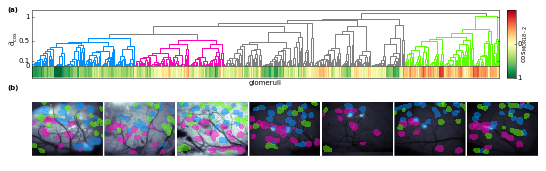

In [103]:
yticks = [0, 0.1, 0.5, 1]
cluster = [379, 384, 402]#,342,356,352,343,370,372,367,375,377]#[324, 298, 352, 360, 354, 365, 363, 258, 385, 359, 366, 369, 384, 401, 397]
num_cluster = len(cluster)

fig = plt.figure(figsize=fig_dim)
gs_meta = matplotlib.gridspec.GridSpec(2, 1, bottom=0.7, top = 0.99, left = 0.05, right=0.99, 
                                       height_ratios=[1,1.4,num_cluster*0.15], hspace=0.04)

num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow_r(1.*cluster.index(clust)/num_cluster) for clust in cluster}

gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 3, gs_meta[0], hspace=0.01, height_ratios=[5,1], 
                                                     wspace=0.05, width_ratios=[16.5,0.3,0.5])

# plot dendrogarm
ax = fig.add_subplot(gs_top[0,0])
top = gs_meta[0].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(a)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
d = dendrogram(link2, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
ax.set_xticks([])
ax.set_yticks([i**factor for i in yticks])
ax.set_yticklabels(yticks)
ax.set_ylabel('$\hat{d}_{cos}$', labelpad=-1)
#ax.set_ylim([0,0.2])

# plot MOR18-2 correlation
ax = fig.add_subplot(gs_top[1,0])
im = ax.imshow(((cor[d['leaves']]).reshape((1,-1))), cmap= RdGr_compact, interpolation='none', 
               aspect='auto', vmin=0, vmax=2)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('glomeruli', labelpad=2)
# colorbar
axbar = fig.add_subplot(gs_top[:,1])
cbar = plt.colorbar(im, cax=axbar)
cbar.set_ticks([0,1])
cbar.set_ticklabels([1,0])
cbar.set_label('$cos_{MOR18-2}$', labelpad=-2)

# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1,:], wspace=0.02)
top = gs_meta[1].get_position(fig).corners()[1,1]
fig.text(0.005, top-0.01, '(b)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts, link, cluster, bg_dict, axbase, clust_colors)

#savepath= os.path.join('Figures', 'chemotopy.png')
#fig.savefig(savepath, bbox_inches='tight', dpi=600)

In [40]:
tunocluster_topplot = ['clust_%d'%i for i in [200, 172, 256, 254, 278]]

In [41]:
spec_toplot = []
for clust in tunocluster_topplot:
    spec_toplot.append([spec_dict[clust][int(cas2molid[i.strip()])] for i in ts_pruned.label_stimuli])
spec_toplot = np.array(spec_toplot).T
norm = np.sum(np.abs(spec_toplot),0)
spec_toplot /= norm

In [42]:
centers_tunocluster = np.dot(fspace_data.T, spec_toplot)

In [43]:
to_embedd = np.vstack([centers_tunocluster.T, fspace_data]) #fspace_data #
dist = squareform(pdist(to_embedd, 'euclidean'))
dist.shape

(49, 49)

In [44]:
embedding = MDS(dissimilarity='precomputed', n_components=2, random_state=3)
out = embedding.fit_transform(dist)

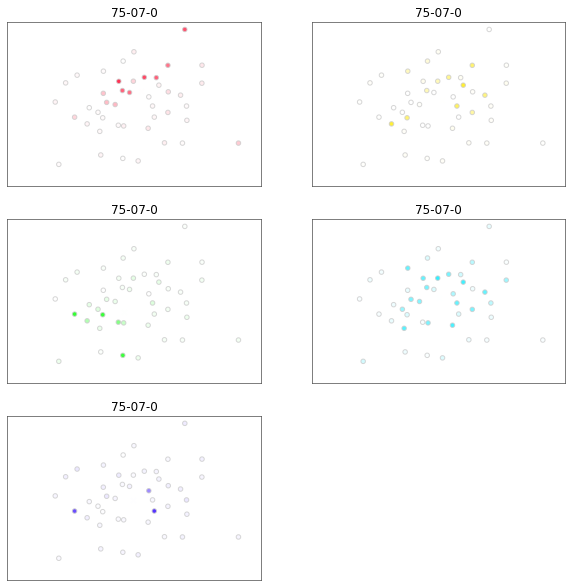

In [45]:
start = 5
fig = plt.figure(figsize = (10,10))
for ind, data in enumerate(spec_toplot.T):
    ax = fig.add_subplot(3, 2, ind+1)
    data /= np.max(data)
    my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap',
                                               [(1,1,1,1), plt.cm.gist_rainbow(1.*ind/len(spec_toplot.T))])
    ax.scatter(out[ind,0], out[ind,1], s=20, marker = 'x', linewidths=1,
                facecolor= my_cmap(1),
                edgecolor= '0.8')
    ax.scatter(out[start:,0], out[start:,1], s=20, linewidths=1,
                facecolor= [my_cmap(i) for i in data],
                edgecolor= '0.8', alpha=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(k)
plt.show()

## Chemotopic embedding

#### Spatial plot of all modes with functiona distance to prototype

/home/jan/Apps/virtenv/standard/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


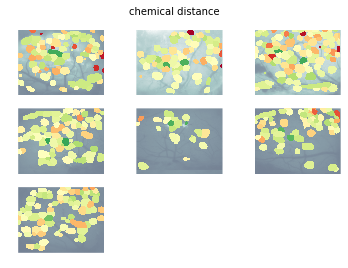

In [46]:
cluster_id = 260
metric = 'cosine'
what = ts

protoype_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
prototype = np.mean(what._series[:,protoype_idx],1)
cor = squareform(pdist(np.hstack([prototype[:,np.newaxis], what._series]).T, metric))[0,1:]

fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(3,int(np.ceil(num_animals/3.)))
axbase = [fig.add_subplot(gs[i]) for i in range(num_animals)]


for measID, ax in zip(animals, axbase):
    bg = bg_dict[measID]
    ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0], vmin=-1, vmax=1)
    ax.set_axis_off() 

for obj_id in range(what.num_objects):
    measID = what.label_objects[obj_id].split('_')[0]
    pos = animals.index(measID)
    base = what.base.shaped2D()[obj_id]
    basecolor = plt.cm.RdYlGn_r(((cor[obj_id])/(np.max(cor)))**0.3) #if cor[obj_id]<1 else '0.7'
    axbase[pos].contourf(base, [0.3,1], colors=[basecolor]) 
    
fig.suptitle('chemical distance')    
plt.show()

#### Distribution of functional distances for spatial neigbours vs. non-neigbours

Neigbours are calculated as overlapping modes after extending the custermodes with dilation 

In [47]:
np.mean(dist[~member_mask])

NameError: name 'member_mask' is not defined

In [48]:
for dilation in range(1, 35, 1):

    thres = 0.6
    #dilation = 2
    metric='euclidean'
    show = False
    
    # get cluster member
    member_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    
    
    # calculate which modes overlap with cluster modes
    neighbour_modes = np.zeros(ts.num_objects).astype('bool')
    for animal in animals:
        animal_mask = np.array([animal in mode for mode in ts.label_objects])
        neighbour_pixel = np.logical_or(ts.base.shaped2D()[animal_mask*member_mask]>thres,0).squeeze()
        if dilation:
            neighbour_pixel = scipy.ndimage.morphology.binary_dilation(neighbour_pixel, iterations=dilation)
        neighbour_modes[animal_mask] = np.max(ts.base._series[animal_mask][:,neighbour_pixel.flatten()],1)>thres
    neighbour_modes[member_mask]=False    
    
    # calculate mode distances
    prototype = np.mean(ts._series[:,member_idx],1)
    dist = squareform(pdist(np.hstack([prototype[:,np.newaxis], ts._series]).T, metric))[0,1:]
    dist_neighbours = dist[neighbour_modes]
    dist_nonneighbours = dist[~(neighbour_modes+member_mask)]
    
    if show:
        # plot distance distribution
        ax = plt.subplot(111)
        ax.hist(dist_nonneighbours, np.linspace(0,50,21), color=['0.5'], normed=True, lw=0, rwidth=1, label='non neighbours')
        ax.hist(dist_neighbours, np.linspace(0,50,21), color='k', normed=True, histtype='step', lw=2, rwidth=1, label= 'neigbours')
        ax.set_xlabel('distance')
        ax.set_ylabel('rel. frequency')
        ax.grid()
        plt.legend()
        
        # plot neighbour modes
        fig = plt.figure()
        gs = matplotlib.gridspec.GridSpec(3,int(np.ceil(num_animals/3.)))
        axbase = [fig.add_subplot(gs[i]) for i in range(num_animals)]
        
        
        for measID, ax in zip(animals, axbase):
            bg = bg_dict[measID]
            ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0], vmin=-1, vmax=1)
            ax.set_axis_off() 
        
        for obj_id in range(what.num_objects):
            measID = what.label_objects[obj_id].split('_')[0]
            pos = animals.index(measID)
            base = what.base.shaped2D()[obj_id]
            basecolor ='g' if neighbour_modes[obj_id] else ('b' if member_mask[obj_id] else 'r')
            axbase[pos].contourf(base, [thres,1], colors=[basecolor], alpha=0.5) # if cor[obj_id]<1 else (1.,0.1,0.1)], alpha=0.9)
        plt.show()
        
        
    # calculate significane of distribution difference
    _, p_mwu = scipy.stats.mannwhitneyu(dist_neighbours, dist_nonneighbours)
    _, p_ks = scipy.stats.ks_2samp(dist_neighbours, dist_nonneighbours)
    _, p_tt = scipy.stats.ttest_ind(dist_neighbours, dist_nonneighbours)
    print ' distance neighbours: %.2f, nonneighbours: %.2f, p_values -> MWU: %.2f, KS: %.2f, T: %.2f'%(np.mean(dist_neighbours),np.mean(dist_nonneighbours), p_mwu, p_ks, p_tt)

/home/jan/Apps/virtenv/standard/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jan/Apps/virtenv/standard/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 5376 but corresponding boolean dimension is 10752


IndexError: index 5747 is out of bounds for axis 1 with size 5376

In [49]:
plt.close('all')